
# Stratification

Commonly we use `KFold` or a `ShuffleSplit` cross-validation strategies to iteratively split our dataset.
However, you should not assume that these approaches are always the best
option: some other cross-validation strategies might be better adapted to your
problem.

Let's start with the concept of stratification by giving an example where we
can get into trouble if we are not careful. Let's load the iris dataset.

## Learning objectives

By the end of this notebook you should be able to:\n
- Explain why a naive KFold split can produce misleading results on ordered data.\n
- Distinguish between shuffling and stratifying, and when to use each.\n
- Use and interpret `StratifiedKFold` to preserve class proportions across folds.\n
- Recognize situations where stratification is not appropriate (e.g., time series, grouped data).

In [1]:
from sklearn.datasets import load_iris

data, target = load_iris(as_frame=True, return_X_y=True)

### Quick note about the dataset

The classic Iris dataset is provided with its target labels in an ordered
fashion (all samples of one class appear together). This ordering is
convenient for human inspection but can cause problems when using
cross-validation strategies that do not shuffle the data first. We'll
see how this ordering leads to folds that completely miss a class in
the training set if we are not careful.

At this point, we create a basic machine-learning model: a logistic
regression. We expect this model to work quite well on the iris dataset since
this is a toy dataset.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())

Once the model is created, we can evaluate it using cross-validation. We start
by using the `KFold` strategy.

Let's review how this strategy works. For such purpose, we define a dataset
with nine samples and split the dataset into three folds (i.e. `n_splits=3`).

### How KFold works (important detail)

`KFold` partitions the dataset into `n_splits` contiguous folds and, by
default, does not shuffle the data before splitting. That means if the
data are ordered by label (as in our Iris target), some folds may contain
only examples from a subset of classes. In turn, the model can be asked to
predict a class it has never seen during training, producing misleadingly
low scores. To avoid this, either shuffle before splitting or use a
stratified CV iterator designed to preserve class proportions across folds.

In [3]:
import numpy as np
from sklearn.model_selection import KFold

data_random = np.random.randn(9, 1)
cv = KFold(n_splits=3)
for train_index, test_index in cv.split(data_random):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [3 4 5 6 7 8] TEST: [0 1 2]
TRAIN: [0 1 2 6 7 8] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]


By defining three splits, we use three samples (1-fold) for testing and six
(2-folds) for training each time. `KFold` does not shuffle by default. It
means that the three first samples are selected for the testing set at the
first split, then the three next three samples for the second split, and the
three next for the last split. In the end, all samples have been used in
testing at least once among the different splits.

Now, let's apply this strategy to check the generalization performance of our
model.

In [4]:
from sklearn.model_selection import cross_validate

cv = KFold(n_splits=3)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)

The average accuracy is 0.000 ± 0.000


### Diagnosing an unexpectedly low score

If cross-validation returns a very poor score (for a model that should work
on a toy dataset), always check whether the training folds contain
representative examples of each class. A simple plot of the target order or
counts per fold (as we do below) will usually reveal whether some folds
entirely miss a class. This is a common debugging step when working with
small or ordered datasets.

It is a real surprise that our model cannot correctly classify any sample in
any cross-validation split. We now check our target's value to understand the
issue.

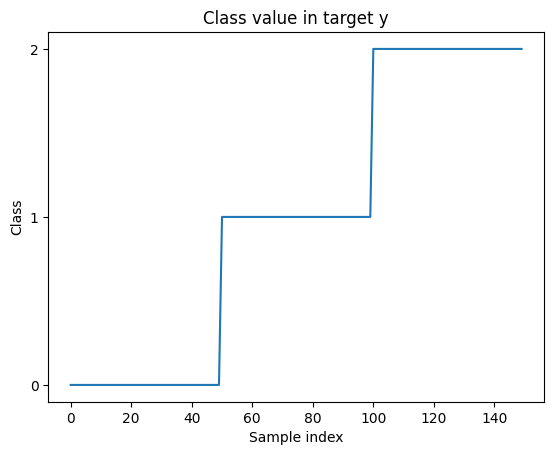

In [5]:
import matplotlib.pyplot as plt

target.plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(target.unique())
_ = plt.title("Class value in target y")

We see that the target vector `target` is ordered. This has some unexpected
consequences when using the `KFold` cross-validation. To illustrate the
consequences, we show the class count in each fold of the cross-validation in
the train and test set.

Let's compute the class counts for both the training and testing sets using
the `KFold` cross-validation, and plot these information in a bar plot.

We iterate given the number of split and check how many samples of each are
present in the training and testing set. We then store the information into
two distinct lists; one for the training set and one for the testing set.

In [6]:
import pandas as pd

n_splits = 3
cv = KFold(n_splits=n_splits)

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())

To plot the information on a single figure, we concatenate the information
regarding the fold within the same dataset.

In [7]:
train_cv_counts = pd.concat(
    train_cv_counts, axis=1, keys=[f"Fold #{idx}" for idx in range(n_splits)]
)
train_cv_counts.index.name = "Class label"
train_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
1,50.0,NaN,50.0
2,50.0,50.0,NaN
0,NaN,50.0,50.0


In [8]:
test_cv_counts = pd.concat(
    test_cv_counts, axis=1, keys=[f"Fold #{idx}" for idx in range(n_splits)]
)
test_cv_counts.index.name = "Class label"
test_cv_counts

,Fold #0,Fold #1,Fold #2
Class label,,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


Now we can represent graphically this information with bar plots.

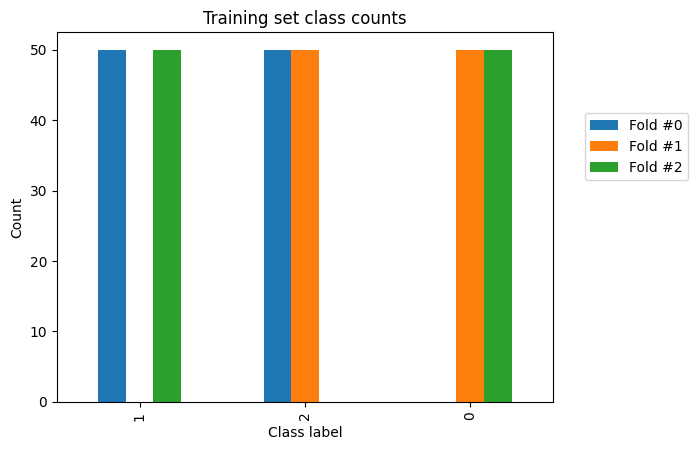

In [9]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set class counts")

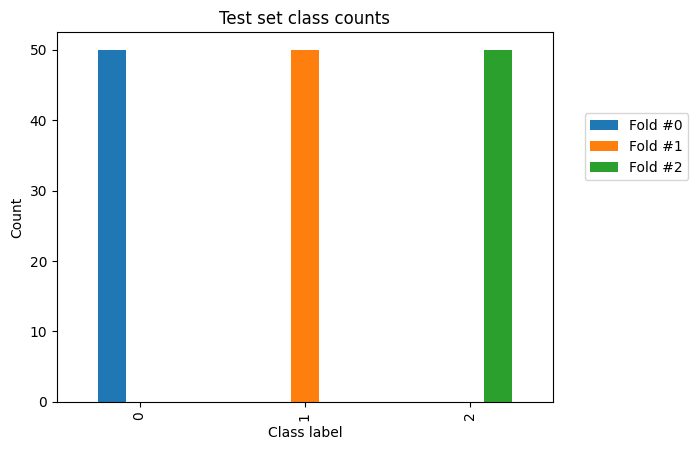

In [10]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set class counts")

We can confirm that in each fold, only two of the three classes are present in
the training set and all samples of the remaining class is used as a test set.
So our model is unable to predict this class that was unseen during the
training stage.

One possibility to solve the issue is to shuffle the data before splitting the
data into three groups.

In [11]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)

The average accuracy is 0.953 ± 0.009


We get results that are closer to what we would expect with an accuracy above
90%. Now that we solved our first issue, it would be interesting to check if
the class frequency in the training and testing set is equal to our original
set's class frequency. It would ensure that we are training and testing our
model with a class distribution that we would encounter in production.

In [12]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
train_cv_counts = pd.concat(
    train_cv_counts, axis=1, keys=[f"Fold #{idx}" for idx in range(n_splits)]
)
test_cv_counts = pd.concat(
    test_cv_counts, axis=1, keys=[f"Fold #{idx}" for idx in range(n_splits)]
)
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

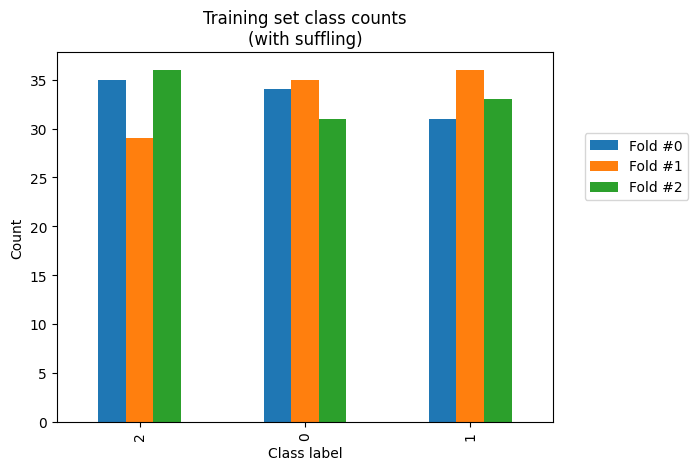

In [13]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set class counts\n(with suffling)")

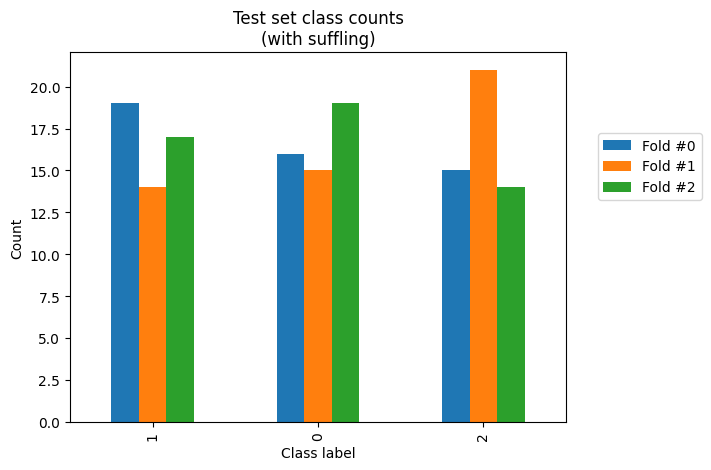

In [14]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set class counts\n(with suffling)")

We see that neither the training and testing sets have the same class
frequencies as our original dataset because the count for each class is
varying a little.

However, one might want to split our data by preserving the original class
frequencies: we want to **stratify** our data by class. In scikit-learn, some
cross-validation strategies implement the stratification; they contain
`Stratified` in their names.

### When to prefer stratification

Use stratified splits when the target is categorical and you want each fold
to reflect the overall class proportions. This is particularly important
for imbalanced classification problems where the rare class must be
represented in both training and test folds to obtain reliable estimates of
performance. Note that stratified splitting is not appropriate for time-
series data (where order matters) or when you need to group by a separate
identifier (use `GroupKFold` instead).

In [15]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3)

In [16]:
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)

The average accuracy is 0.967 ± 0.009


In [17]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
train_cv_counts = pd.concat(
    train_cv_counts, axis=1, keys=[f"Fold #{idx}" for idx in range(n_splits)]
)
test_cv_counts = pd.concat(
    test_cv_counts, axis=1, keys=[f"Fold #{idx}" for idx in range(n_splits)]
)
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

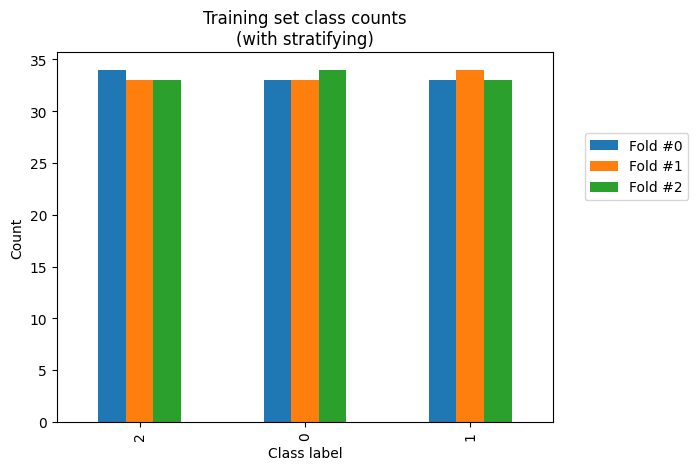

In [18]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set class counts\n(with stratifying)")

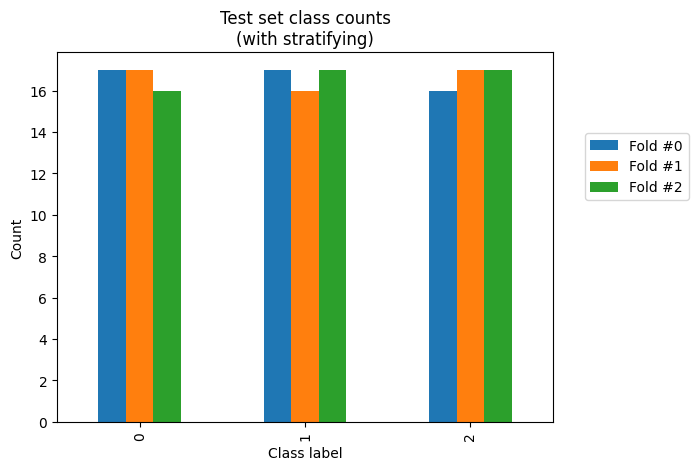

In [19]:
test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set class counts\n(with stratifying)")

In this case, we observe that the class counts are very close both in the
train set and the test set. The difference is due to the small number of
samples in the iris dataset.

In other words, stratifying is more effective than just shuffling when it
comes to making sure that the distributions of classes in all the folds are
representative of the entire dataset. As training and testing folds have
similar class distributions, stratifying leads to a more realistic measure of
the model’s ability to generalize. This is specially important when the
performance metrics depend on the proportion of the positive class, as we will
see in a future notebook.

The interested reader can learn about other stratified cross-validation
techniques in the [scikit-learn user
guide](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels).

## Exercises and further exploration

Try the following exercises to deepen your understanding:\n
1. Create an artificially imbalanced version of Iris (e.g., keep only 10%
   of one class) and compare the variance of accuracy across folds with
   `KFold` (with shuffling) and `StratifiedKFold`. Observe differences in
   per-fold metrics such as precision and recall.\n
2. Replace the classifier with a different algorithm (e.g., a decision
   tree) and check whether stratification has a similar impact on its
   cross-validation scores.\n
3. Read about `GroupKFold` and `TimeSeriesSplit` and write a short note on
   when each is appropriate.\n

Additional reading: scikit-learn's cross-validation guide linked above, and
the chapter on model evaluation in any modern ML textbook (for example
Hastie, Tibshirani, and Friedman's 
).